Enter a ticker symbol: INR=X
[*********************100%***********************]  1 of 1 completed


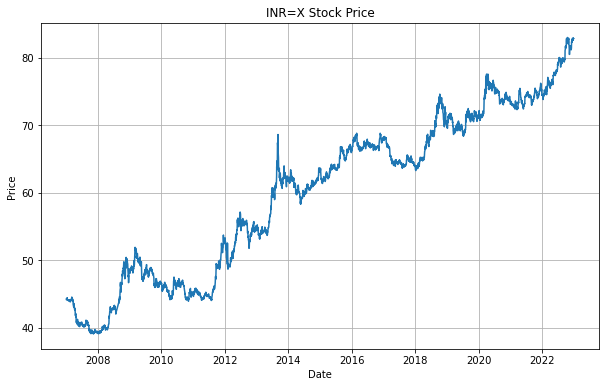

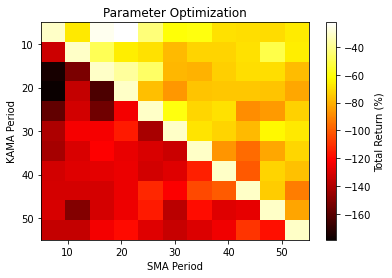

Optimal parameters: [20.  5.]
Total return: 178.49826399230125


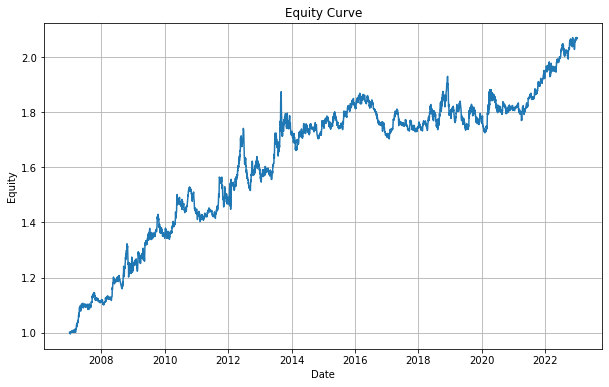

Max Drawdown: -0.22537357468314956


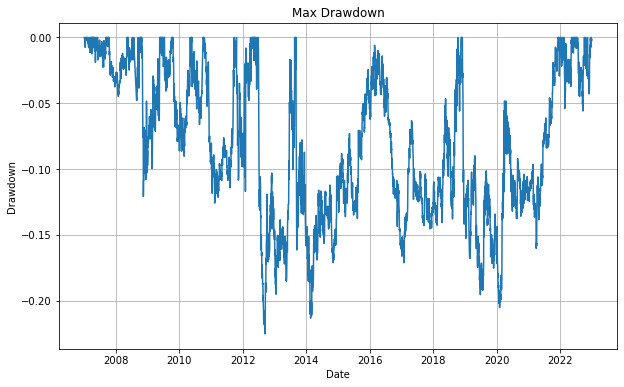

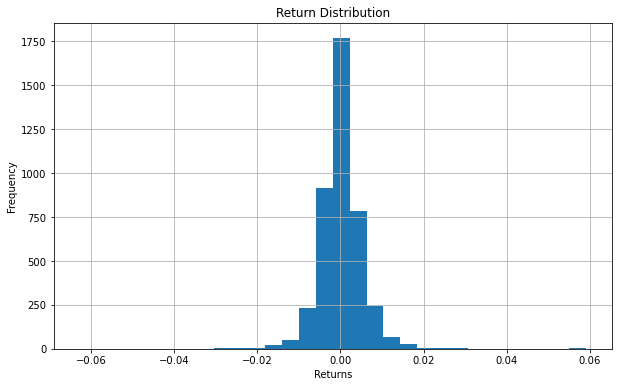

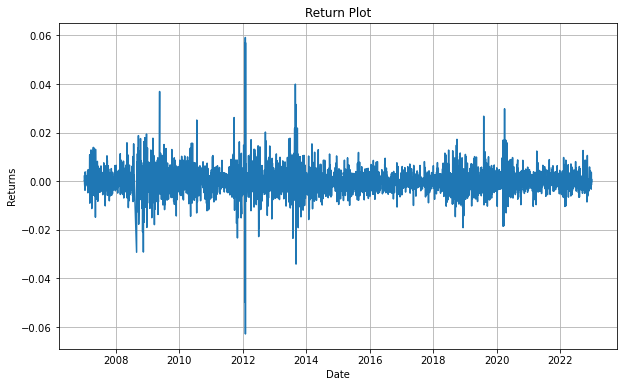

Sharpe Ratio: 0.5708432885449659
[*********************100%***********************]  1 of 1 completed


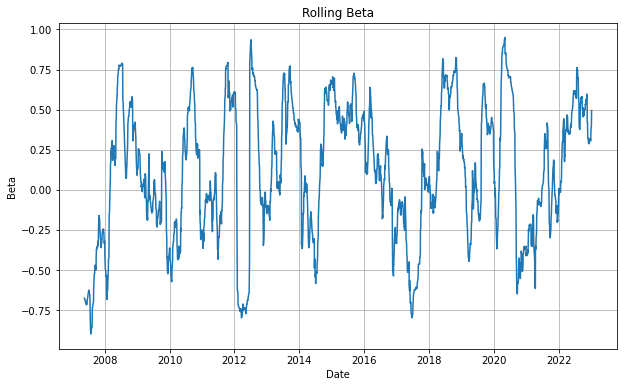

In [26]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import brute
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import arch

# Step 1: Define the moving average functions
def calculate_kama(data, n=10):
    kama = data['Close'].rolling(n).mean()
    return kama


def calculate_sma(data, n=50):
    sma = data['Close'].rolling(n).mean()
    return sma

# Step 2: Define the trading strategy
def calculate_signals(data, kama_period=10, sma_period=50):
    kama = calculate_kama(data, kama_period)
    sma = calculate_sma(data, sma_period)

    # Ensure that the lengths of kama and sma are the same
    min_length = min(len(kama), len(sma))
    kama = kama[-min_length:]
    sma = sma[-min_length:]

    signals = pd.Series(np.where(sma > kama, 1, -1), index=data.index[-min_length:])
    return signals

# Step 3: Define the objective function for optimization
def objective_function(params, data):
    kama_period, sma_period = params
    signals = calculate_signals(data, int(kama_period), int(sma_period))
    data['Position'] = signals
    data['Returns'] = data['Close'].pct_change() * data['Position'].shift()
    total_return = (data['Returns'].sum() + 1) * 100
    return -total_return  # Negative sign for maximizing the return

# Step 4: Perform parameter optimization with visualization
def optimize_parameters(data):
    grid = (slice(5, 60, 5), slice(5, 60, 5))  # Define the parameter grid
    result = brute(objective_function, grid, args=(data,), full_output=True, finish=None)
    
    # Extract optimization results
    kama_periods = np.arange(5, 60, 5)
    sma_periods = np.arange(5, 60, 5)
    returns = result[3].reshape(len(kama_periods), len(sma_periods))

    # Plot optimization results
    fig, ax = plt.subplots()
    im = ax.imshow(returns, cmap='hot', extent=[min(sma_periods), max(sma_periods), max(kama_periods), min(kama_periods)], aspect='auto')
    ax.set_xlabel('SMA Period')
    ax.set_ylabel('KAMA Period')
    ax.set_title('Parameter Optimization')
    fig.colorbar(im, ax=ax, label='Total Return (%)')
    plt.show()
    
    return result[0]  # Optimal parameters

# Step 5: Retrieve data from Yahoo Finance and plot the chart
def get_stock_data(ticker_symbol, start_date, end_date):
    data = yf.download(ticker_symbol, start=start_date, end=end_date)
    data.reset_index(inplace=True)
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    
    # Plot the chart
    plt.figure(figsize=(10, 6))
    plt.plot(data['Close'])
    plt.title(f'{ticker_symbol} Stock Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()
    
    return data

# Step 6: Repeatable code for different tickers
def run_strategy():
    ticker_symbol = input("Enter a ticker symbol: ")
    start_date = '2007-01-01'
    end_date = '2023-01-01'

    data = get_stock_data(ticker_symbol, start_date, end_date)
    optimal_params = optimize_parameters(data)
    kama_period, sma_period = optimal_params
    print("Optimal parameters:", optimal_params)

    signals = calculate_signals(data, int(kama_period), int(sma_period))
    data['Position'] = signals
    data['Returns'] = data['Close'].pct_change() * data['Position'].shift()
    total_return = (data['Returns'].sum() + 1) * 100
    print("Total return:", total_return)

    # Calculate equity curve
    data['EquityCurve'] = (data['Returns'] + 1).cumprod()

    # Plot equity curve
    plt.figure(figsize=(10, 6))
    plt.plot(data['EquityCurve'])
    plt.title("Equity Curve")
    plt.xlabel("Date")
    plt.ylabel("Equity")
    plt.grid(True)
    plt.show()

    # Calculate max drawdown
    data['Peak'] = data['EquityCurve'].cummax()
    data['Drawdown'] = data['EquityCurve'] - data['Peak']
    max_drawdown = data['Drawdown'].min()
    print("Max Drawdown:", max_drawdown)

    # Plot max drawdown
    plt.figure(figsize=(10, 6))
    plt.plot(data['Drawdown'])
    plt.title("Max Drawdown")
    plt.xlabel("Date")
    plt.ylabel("Drawdown")
    plt.grid(True)
    plt.show()

    # Return distribution chart
    plt.figure(figsize=(10, 6))
    plt.hist(data['Returns'].dropna(), bins=30)
    plt.title("Return Distribution")
    plt.xlabel("Returns")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # Return plot in time series
    plt.figure(figsize=(10, 6))
    plt.plot(data['Returns'])
    plt.title("Return Plot")
    plt.xlabel("Date")
    plt.ylabel("Returns")
    plt.grid(True)
    plt.show()

    # Sharpe ratio
    sharpe_ratio = data['Returns'].mean() / data['Returns'].std() * np.sqrt(252)
    print("Sharpe Ratio:", sharpe_ratio)

    # Rolling beta
    benchmark = yf.download(ticker_symbol, start=start_date, end=end_date)
    benchmark_returns = benchmark['Close'].pct_change()
    data['BenchmarkReturns'] = benchmark_returns
    rolling_window = 100
    rolling_betas = []
    for i in range(len(data) - rolling_window + 1):
        window_data = data.iloc[i:i + rolling_window].dropna()
        model = sm.OLS(window_data['Returns'], sm.add_constant(window_data['BenchmarkReturns'])).fit()
        rolling_betas.append(model.params[1])

    # Plot rolling beta
    plt.figure(figsize=(10, 6))
    plt.plot(data.index[rolling_window - 1:], rolling_betas)
    plt.title("Rolling Beta")
    plt.xlabel("Date")
    plt.ylabel("Beta")
    plt.grid(True)
    plt.show()

# Example usage
run_strategy()